In [121]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib widget


def read_omg_csv(path_palm_data: str, 
                 n_omg_channels: int = 50, 
                 n_acc_channels: int = 3, 
                 n_gyr_channels: int = 3,
                 n_enc_channels: int = 6,
                 n_mag_channels: int = 0, 
                 button_ch: bool = True, 
                 sync_ch: bool = True, 
                 timestamp_ch: bool = True) -> pd.DataFrame:
    
    '''
    Reads CSV data for OMG data
    NB: data must be separated by " " separator

        Parameters:
                path_palm_data  (str): path to csv data file
                n_omg_channels  (int): Number of OMG channels
                n_acc_channels  (int): Number of Accelerometer channels, default = 0
                n_gyr_channels  (int): Number of Gyroscope channels, default = 0
                n_mag_channels  (int): Number of Magnetometer channels, default = 0
                n_enc_channels  (int): Number of Encoder channels, default = 0
                button_ch      (bool): If button channel is present, default = True
                sync_ch        (bool): If synchronization channel is present, default = True
                timestamp_ch   (bool): If timestamp channel is present, default = True

        Returns:
                df_raw (pd.DataFrame): Parsed pandas Dataframe with OMG data
    '''
    
    df_raw = pd.read_csv(path_palm_data, sep=' ', 
                         header=None, 
                         skipfooter=1, 
                         skiprows=1, 
                         engine='python')
    columns = np.arange(n_omg_channels).astype('str').tolist()
    
    for label, label_count in zip(['ACC', 'GYR', 'MAG', 'ENC'], 
                                  [n_acc_channels, n_gyr_channels, n_mag_channels, n_enc_channels]):
        columns = columns + ['{}{}'.format(label, i) for i in range(label_count)]
        
    if button_ch:
        columns = columns + ['BUTTON']
        
    if sync_ch:
        columns = columns + ['SYNC']
        
    if timestamp_ch:
        columns = columns + ['ts']
        
    df_raw.columns = columns
    
    return df_raw

sprint1_pilote1_gestures = read_omg_csv('sprint1_pilote1_gestures.palm')
sprint2_pilote1_gestures = read_omg_csv('sprint2_pilote1_gestures.palm')
sprint2_pilote2_gestures = read_omg_csv('sprint2_pilote2_gestures.palm')
sprint3_pilote1_mount1_gestures = read_omg_csv('sprint3_pilote1_mount1_gestures.palm')
sprint3_pilote1_mount2_gestures = read_omg_csv('sprint3_pilote1_mount2_gestures.palm')

sprint1_pilote1_gestures_protocol = pd.read_csv('sprint1_pilote1_gestures.palm.protocol.csv')
sprint2_pilote1_gestures_protocol = pd.read_csv('sprint2_pilote1_gestures.palm.protocol.csv')
sprint2_pilote2_gestures_protocol = pd.read_csv('sprint2_pilote2_gestures.palm.protocol.csv')
sprint3_pilote1_mount1_gestures_protocol = pd.read_csv('sprint3_pilote1_mount1_gestures.palm.protocol.csv')
sprint3_pilote1_mount2_gestures_protocol = pd.read_csv('sprint3_pilote1_mount2_gestures.palm.protocol.csv')

sprint2_pilote1_fingers = read_omg_csv('sprint2_pilote1_fingers.palm')
sprint2_pilote2_fingers = read_omg_csv('sprint2_pilote2_fingers.palm')


OMG_CH = [str(i) for i in range(50)]
GLOVE_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']

# Соединим данные 2-х пилотов
X_gestures = np.vstack([
    #sprint1_pilote1_gestures[OMG_CH].values,
    #sprint2_pilote1_gestures[OMG_CH].values,
    #sprint2_pilote2_gestures[OMG_CH].values,
    sprint3_pilote1_mount1_gestures[OMG_CH].values,
    sprint3_pilote1_mount2_gestures[OMG_CH].values,
    ])
y_gestures = np.vstack([
    #sprint1_pilote1_gestures[GLOVE_CH].values,
    #sprint2_pilote1_gestures[GLOVE_CH].values,
    #sprint2_pilote2_gestures[GLOVE_CH].values,
    sprint3_pilote1_mount1_gestures[GLOVE_CH].values,
    sprint3_pilote1_mount2_gestures[GLOVE_CH].values,
    ])

X_fingers = np.vstack([
    sprint2_pilote1_fingers[OMG_CH], 
    sprint2_pilote2_fingers[OMG_CH]
    ])
y_fingers = np.vstack([
    sprint2_pilote1_fingers[GLOVE_CH], 
    sprint2_pilote2_fingers[GLOVE_CH]
    ])

X_gestures.shape, y_gestures.shape, X_fingers.shape, y_fingers.shape

((39197, 50), (39197, 6), (31307, 50), (31307, 6))

In [130]:
merged_1 = sprint1_pilote1_gestures.merge(sprint1_pilote1_gestures_protocol, how='left', left_on='SYNC', right_on='epoch')
merged_2 = sprint2_pilote1_gestures.merge(sprint2_pilote1_gestures_protocol, how='left', left_on='SYNC', right_on='epoch')
merged_3 = sprint2_pilote2_gestures.merge(sprint2_pilote2_gestures_protocol, how='left', left_on='SYNC', right_on='epoch')
merged_mount1 = sprint3_pilote1_mount1_gestures.merge(sprint3_pilote1_mount1_gestures_protocol, how='left', left_on='SYNC', right_on='epoch')
merged_mount2 = sprint3_pilote1_mount2_gestures.merge(sprint3_pilote1_mount2_gestures_protocol, how='left', left_on='SYNC', right_on='epoch')
merged = pd.concat([merged_mount1, merged_mount2])
merged.shape

(39197, 77)

In [87]:
merged_1[OMG_CH].values[31850] #thumb
merged_1[OMG_CH].values[40800] #thumb
merged_1[OMG_CH].values[32000] #pistol
merged_1[OMG_CH].values[40950] #pistol
merged_1[OMG_CH].values[32150] #ok
merged_1[OMG_CH].values[41100] #ok
merged_1[OMG_CH].values[32300] #grab
merged_1[OMG_CH].values[41250] #grab

merged_1[OMG_CH].values[31770] #relax
merged_1[OMG_CH].values[40720] #relax
merged_1[OMG_CH].values[31920] #relax
merged_1[OMG_CH].values[40870] #relax
merged_1[OMG_CH].values[32070] #relax
merged_1[OMG_CH].values[41020] #relax
merged_1[OMG_CH].values[32220] #relax
merged_1[OMG_CH].values[41170] #relax

array([1150,   49, 1637,   96,    6, 2418,   27,   28, 1863,   49,   37,
         32, 2575,   21,   52, 2746,   11,  963,   61, 2875,   10, 2574,
         81,    9, 3183,   60,    6, 2598,    8, 2441, 1483,   36,   83,
       1984,   15,   64,  902,   54, 1757,   19,   17,    8,   12,   34,
          4,    6,   23,   13,    9,    8], dtype=int64)

In [88]:
df = pd.DataFrame({
    'thumb':merged_1[OMG_CH].values[31850],
    'thumb_2':merged_1[OMG_CH].values[40800],
    'pistol':merged_1[OMG_CH].values[32000],
    'pistol_2':merged_1[OMG_CH].values[40950],
    'ok':merged_1[OMG_CH].values[32150],
    'ok_2':merged_1[OMG_CH].values[41100],
    'grab':merged_1[OMG_CH].values[32300],
    'grab_2':merged_1[OMG_CH].values[41250],
    'relax':merged_1[OMG_CH].values[31770],
    'relax_1':merged_1[OMG_CH].values[40720],
    'relax_2':merged_1[OMG_CH].values[31920],
    'relax_3':merged_1[OMG_CH].values[40870],
    'relax_4':merged_1[OMG_CH].values[32070],
    'relax_5':merged_1[OMG_CH].values[41020],
    'relax_6':merged_1[OMG_CH].values[32220],
    'relax_7':merged_1[OMG_CH].values[41170],
    }).T

df.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
thumb,1569,6,1851,98,5,2536,25,32,2237,37,...,20,11,0,33,6,12,20,4,11,4
thumb_2,1329,8,1738,85,7,2463,22,29,2157,35,...,19,12,10,33,8,6,23,0,10,6
pistol,1812,5,1811,121,8,2615,33,53,2000,54,...,21,6,9,32,16,11,24,5,11,6
pistol_2,1356,14,1389,108,6,2293,30,44,1816,55,...,17,7,16,30,6,8,22,0,0,6
ok,1505,7,1711,102,5,2496,26,38,1933,48,...,18,8,6,32,0,11,22,4,6,7


In [89]:
df['mean'] = df[np.arange(50)].mean(axis=1)
df['std'] = df[np.arange(50)].std(axis=1)
df['distance'] = df[np.arange(50)].apply(lambda x: np.sqrt(np.sum((x - np.ones(50) ** 2))), axis=1)
df['lenght'] = df[np.arange(50)].apply(lambda x: np.linalg.norm(x), axis=1)
df['scalar'] = df[np.arange(50)].apply(lambda x: np.dot(x, np.ones(50)), axis=1)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,mean,std,distance,lenght,scalar
thumb,1569,6,1851,98,5,2536,25,32,2237,37,...,12,20,4,11,4,746.74,1121.099894,193.098421,9458.721637,37337.0
thumb_2,1329,8,1738,85,7,2463,22,29,2157,35,...,6,23,0,10,6,707.92,1072.239671,188.005319,9021.792172,35396.0
pistol,1812,5,1811,121,8,2615,33,53,2000,54,...,11,24,5,11,6,762.56,1120.316686,195.135850,9517.103131,38128.0
pistol_2,1356,14,1389,108,6,2293,30,44,1816,55,...,8,22,0,0,6,656.86,983.099119,181.088376,8302.467284,32843.0
ok,1505,7,1711,102,5,2496,26,38,1933,48,...,11,22,4,6,7,719.40,1076.418684,189.525724,9091.314536,35970.0


# Preprocessing

In [90]:
def get_diff(array, min=-400, max=400):
    new_array = np.sum(array, axis=1) - np.sum(np.vstack([array[1:], array[:1]]), axis=1)
    new_array[(new_array < 0) & (new_array > min)] = 0
    new_array[(new_array > 0) & (new_array < max)] = 0
    return new_array

def classer(array, min=0.1, max=0.6):
    new_array = np.sum(array, axis=1)
    new_array[new_array <= np.quantile(new_array, 0.1)] = 0
    new_array[(new_array > np.quantile(new_array, 0.1)) & (new_array < np.quantile(new_array, 0.6))] = 1
    new_array[(new_array != 0) & (new_array != 1)] = 2
    return new_array

# Modeling

In [91]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

# model = DecisionTreeRegressor()
model = LinearRegression()

model.fit(
    X_gestures,
    y_gestures
)

LinearRegression()

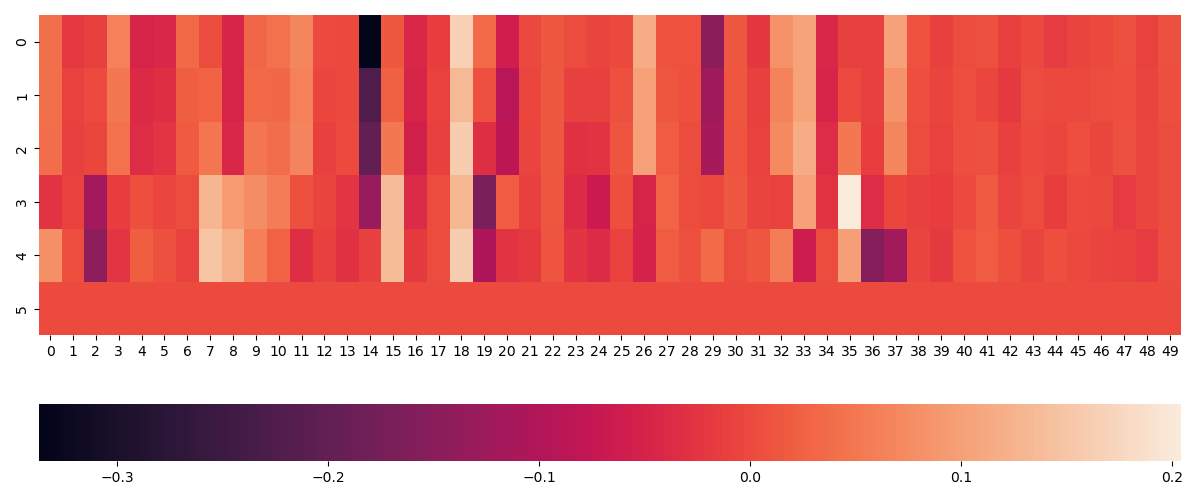

In [92]:
import seaborn as sns

plt.figure(figsize=(12, 5)) # 
sns.heatmap(model.coef_, cbar_kws={"orientation": "horizontal"})
plt.tight_layout()

## Prediction

In [93]:
y_pred = model.predict(X_gestures)
y_pred

array([[37.72348427, 36.70797204, 27.26733322, -2.33543154, -2.97461744,
         0.        ],
       [37.24785752, 36.24586484, 27.50930684, -0.3200793 , -0.88358305,
         0.        ],
       [39.39259432, 38.3214819 , 29.57857768, -0.80897082, -2.67109299,
         0.        ],
       ...,
       [24.60558705, 37.38879478, 38.05814216, 28.294893  , 17.58563222,
         0.        ],
       [26.73485171, 38.35872575, 42.3555915 , 46.12705484, 33.12040991,
         0.        ],
       [13.72655587, 29.82535336, 31.90642553, 22.49613399, 13.21585186,
         0.        ]])

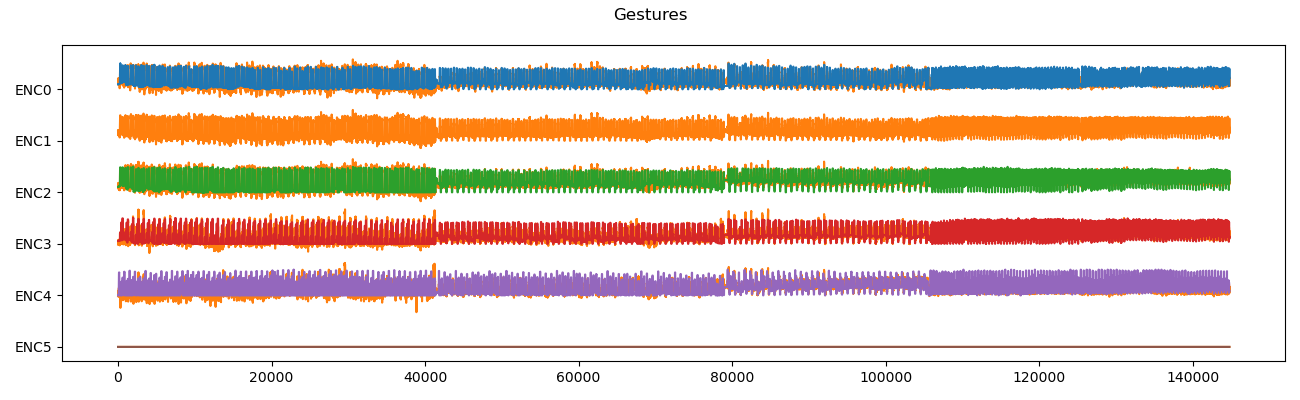

In [94]:
fig, axes = plt.subplots(1, 1, figsize=(13, 4))

plt.sca(axes)
lines = []
labels = []
yticks = -np.arange(len(GLOVE_CH)) * 200

p = plt.plot(y_pred + yticks, c='C1', linestyle='-')
p = plt.plot(y_gestures + yticks, linestyle='-')

plt.yticks(yticks, GLOVE_CH)
plt.suptitle(f'Gestures')
plt.tight_layout()

## Metrics

In [95]:
from sklearn.metrics import mean_squared_error as mse

def MSE(y, y_pred):
    """_получение среднеквадратичной ошибки для каждого таргета_

    """
    ENC0 = mse(y[:,0], y_pred[:,0])
    ENC1 = mse(y[:,1], y_pred[:,1])
    ENC2 = mse(y[:,2], y_pred[:,2])
    ENC3 = mse(y[:,3], y_pred[:,3])
    ENC4 = mse(y[:,4], y_pred[:,4])
    ENC5 = mse(y[:,5], y_pred[:,5])
    return pd.Series([ENC0, ENC1, ENC2, ENC3, ENC4, ENC5])

metrics = MSE(y_gestures, y_pred)
metrics = pd.Series(metrics)

print('Train')
display(metrics)

Train


0    182.593965
1    187.433433
2    165.352051
3    288.898057
4    436.994584
5      0.000000
dtype: float64

In [96]:
def get_distance(array):
    res = []
    for i in np.arange(X_gestures.shape[0]):
        res.append(np.sqrt(np.sum((array[i] - np.ones(50) ** 2))))
    res = np.array(res)
    return res

def get_lenght(array):
    res = []
    for i in np.arange(X_gestures.shape[0]):
        res.append(np.linalg.norm(array[i]))
    res = np.array(res)
    return res

def get_scalar(array):
    res = []
    for i in np.arange(X_gestures.shape[0]):
        res.append(np.dot(array[i], np.ones(50)))
    res = np.array(res)
    return res

In [103]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

new_data = np.vstack([
    X_gestures[:,np.arange(50)].mean(axis=1), 
    X_gestures[:,np.arange(50)].std(axis=1),
    get_distance(X_gestures[:,np.arange(50)]),
    get_lenght(X_gestures[:,np.arange(50)]),
    get_scalar(X_gestures[:,np.arange(50)])
    ]).T

new_data = scaler.fit_transform(new_data)

In [105]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

# model = DecisionTreeRegressor()
model_1 = LinearRegression()

model_1.fit(
    new_data,
    y_gestures
)

y_pred_1 = model_1.predict(new_data)

metrics_1 = MSE(y_gestures, y_pred_1)
metrics_1 = pd.Series(metrics_1)

print('New_data')
display(metrics_1)

New_data


0    567.962445
1    529.782049
2    598.172471
3    613.364177
4    714.734373
5      0.000000
dtype: float64

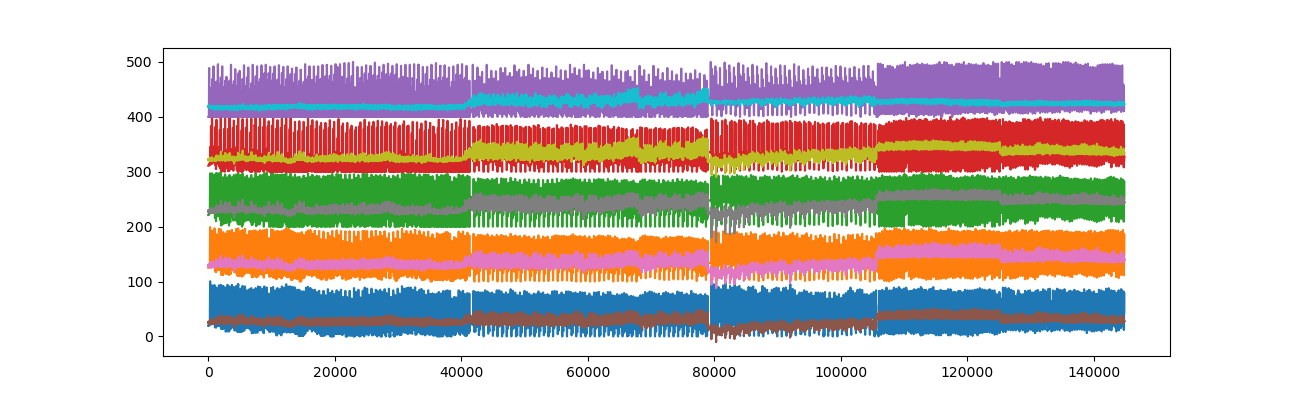

In [107]:
plt.cla()
plt.clf()
fig, ax = plt.subplots(figsize=(13, 4))

ax.plot(y_gestures[:,0])
ax.plot(y_gestures[:,1] + 100)
ax.plot(y_gestures[:,2] + 200)
ax.plot(y_gestures[:,3] + 300)
ax.plot(y_gestures[:,4] + 400)

ax.plot(y_pred_1[:,0])
ax.plot(y_pred_1[:,1] + 100)
ax.plot(y_pred_1[:,2] + 200)
ax.plot(y_pred_1[:,3] + 300)
ax.plot(y_pred_1[:,4] + 400)

In [113]:
sorted_data = np.sort(X_gestures)

In [118]:
X_gestures[1000].mean() == sorted_data[1000]

True

In [119]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

# model = DecisionTreeRegressor()
model_2 = LinearRegression()

model_2.fit(
    sorted_data,
    y_gestures
)

y_pred_2 = model_2.predict(sorted_data)

metrics_2 = MSE(y_gestures, y_pred_2)
metrics_2 = pd.Series(metrics_2)

print('Sorted_data')
display(metrics_2)

Sorted_data


0    331.447407
1    317.959074
2    298.146782
3    390.406666
4    570.739484
5      0.000000
dtype: float64

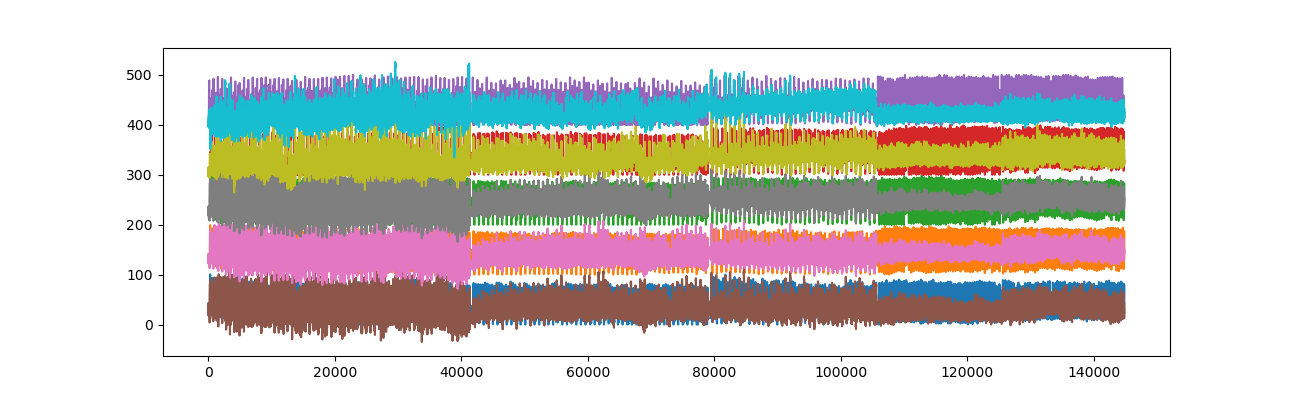

In [120]:
plt.cla()
plt.clf()
fig, ax = plt.subplots(figsize=(13, 4))

ax.plot(y_gestures[:,0])
ax.plot(y_gestures[:,1] + 100)
ax.plot(y_gestures[:,2] + 200)
ax.plot(y_gestures[:,3] + 300)
ax.plot(y_gestures[:,4] + 400)

ax.plot(y_pred[:,0])
ax.plot(y_pred[:,1] + 100)
ax.plot(y_pred[:,2] + 200)
ax.plot(y_pred[:,3] + 300)
ax.plot(y_pred[:,4] + 400)

In [164]:
merged['Ring_stretch'].value_counts()

0.0    36934
1.0     2263
Name: Ring_stretch, dtype: int64

In [167]:
merged['movements'] = merged['Thumb_stretch'] + merged['Index_stretch'] + merged['Middle_stretch'] + merged['Ring_stretch'] + merged['Pinky_stretch']
merged['movements'] = merged['movements'].apply(lambda x: 0 if x==0 else 1)
merged['movements'].value_counts()


0    36934
1     2263
Name: movements, dtype: int64

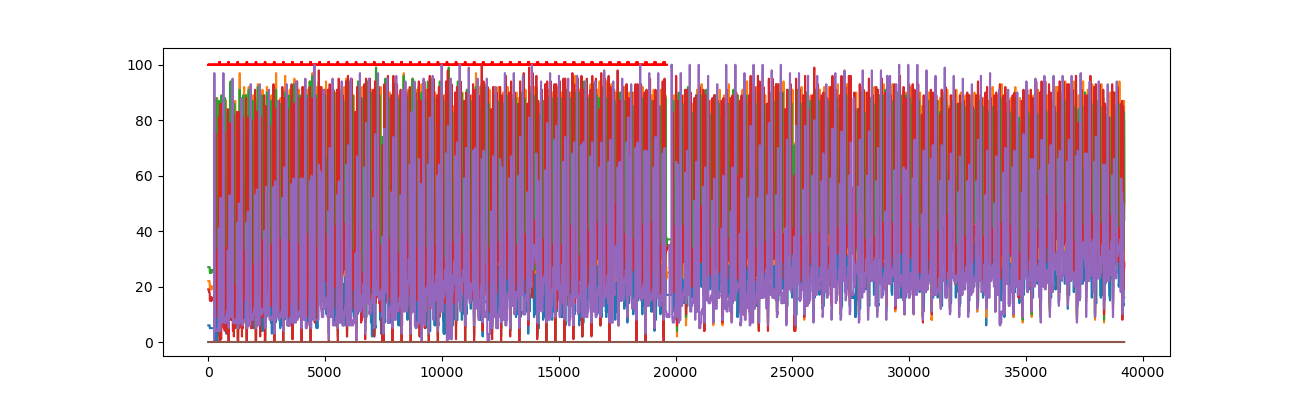

In [169]:
plt.cla()
plt.clf()
fig, ax = plt.subplots(figsize=(13, 4))

ax.plot(merged['movements'] + 100, color='red')
ax.plot(y_gestures)

In [146]:
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import classification_report

X = X_gestures
y = merged['Thumb_stretch']

RC = RidgeClassifier().fit(X, y)

y_pred_class = RC.predict(X_gestures)
print(classification_report(y, y_pred_class))


              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     36934
         1.0       0.93      0.13      0.23      2263

    accuracy                           0.95     39197
   macro avg       0.94      0.56      0.60     39197
weighted avg       0.95      0.95      0.93     39197



In [148]:
y.shape

(39197,)

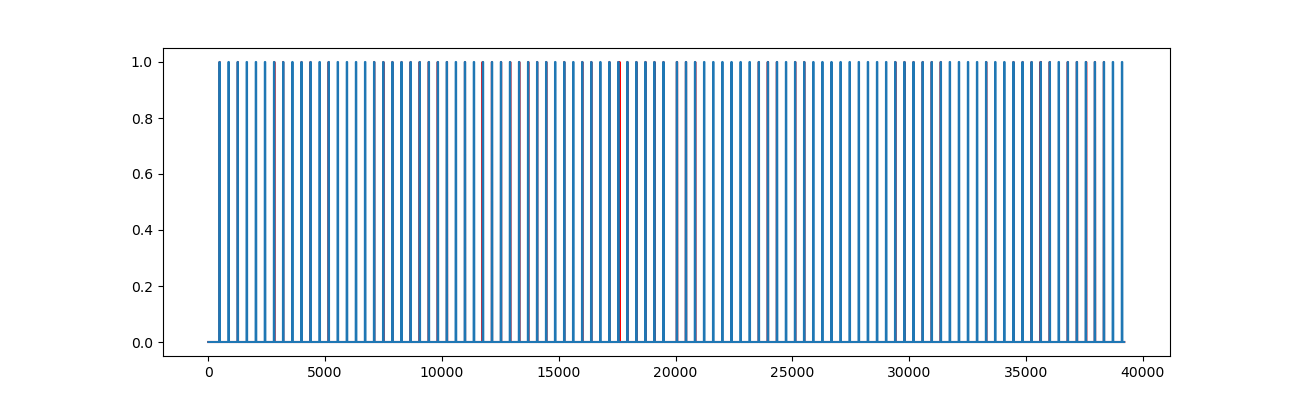

In [150]:
plt.cla()
plt.clf()
fig, ax = plt.subplots(figsize=(13, 4))

ax.plot(y_pred_class, color='red')
ax.plot(y.values)

# Real-time inference

In [24]:
import time
#import serial
from IPython.display import clear_output

In [25]:
crc_table = [
    54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
    111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
    113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
    179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
    115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
    88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
    97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
    45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
    153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
    114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
    215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
    0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
    18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
    57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
    193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
    213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
    137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
    67, 112, 109, 78, 114, 165, 244, 183, 121
];
    
def get_crc(data, count):
    result = 0x00
    l = count
    while (count>0):   
        result = crc_table[result ^ data[l-count]]
        count -= 1;
    return result;

def drv_abs_one(ser, control):
    if ser is None:
        return
    pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
    pack[-1] = get_crc(pack[1:], 9)
    return (pack, ser.write(bytearray(pack)))

## Inference Utils: Put your code here

In [26]:
def preprocessing(x):
    # x - sample vector
    y = x
    return y

def inference(x):
    y = model.predict([x])[0] 
    return y

def postprocessing(x, prev):
    if prev is None:
        y = x
    else:
        y = x*0.1 + prev*0.9 # Holt-Winters filter
    return y

def commands(x):
    y = np.round(np.clip(x / 100, 0, 1)*100).astype(int)
    return y

## Inference

### Offline (dataset)

In [28]:
sprint3_pilote1_mount2_gestures[OMG_CH]

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,9,8,0,2,22,10,4,6,7,28,...,21,22,20,0,4,13,9,0,42,26
1,4,11,0,16,0,9,1,5,16,0,...,36,32,16,2,12,14,0,4,24,16
2,8,9,4,0,4,22,4,5,16,0,...,28,30,10,7,12,18,8,5,35,24
3,8,13,9,6,5,0,4,1,12,10,...,44,32,2,11,5,2,2,0,42,28
4,15,7,8,13,4,0,3,7,0,7,...,30,32,12,14,13,1,6,5,36,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19623,7,0,2,34,38,0,0,20,0,0,...,23,77,25,40,1,29,0,36,94,0
19624,17,9,0,0,25,14,15,13,26,20,...,26,19,3,19,4,24,6,1,41,12
19625,0,3,11,22,10,0,0,0,20,28,...,34,14,11,0,55,20,18,19,26,46
19626,0,0,2,18,32,22,18,30,65,30,...,25,24,16,21,4,6,7,9,39,30


In [29]:
df_sim = sprint3_pilote1_mount2_gestures[OMG_CH].copy().iloc[:10000]
# df_sim = free_movements.iloc[:10000]
print(df_sim.shape)

(10000, 50)


In [30]:
TIMEOUT = 0.033
DEBUG = False
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
}
while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    # [/Data logging]

    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 

not enough values to unpack (expected 3, got 0)
not enough values to unpack (expected 3, got 0)
not enough values to unpack (expected 3, got 0)
not enough values to unpack (expected 3, got 0)
not enough values to unpack (expected 3, got 0)
not enough values to unpack (expected 3, got 0)
not enough values to unpack (expected 3, got 0)
not enough values to unpack (expected 3, got 0)
not enough values to unpack (expected 3, got 0)
not enough values to unpack (expected 3, got 0)
not enough values to unpack (expected 3, got 0)
not enough values to unpack (expected 3, got 0)
not enough values to unpack (expected 3, got 0)
not enough values to unpack (expected 3, got 0)
not enough values to unpack (expected 3, got 0)
not enough values to unpack (expected 3, got 0)
not enough values to unpack (expected 3, got 0)
not enough values to unpack (expected 3, got 0)
not enough values to unpack (expected 3, got 0)
not enough values to unpack (expected 3, got 0)
not enough values to unpack (expected 3,

In [14]:
for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (10000, 50)
enc_sample.shape = (10000, 6)
sample_preprocessed.shape = (10000, 50)
y_predicted.shape = (10000, 6)
y_postprocessed.shape = (10000, 6)
y_commands.shape = (10000, 6)


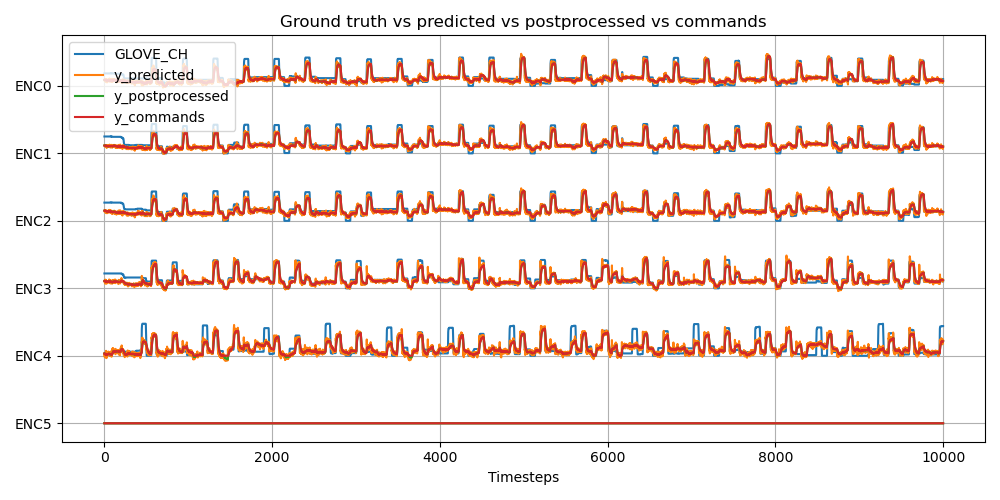

In [15]:
fig = plt.figure(figsize=(10, 5))

lines = []
labels = []

plots = plt.plot(df_sim[GLOVE_CH].values - np.arange(len(GLOVE_CH)) * 200, c='C0')
lines += [plots[0]]
labels += ['GLOVE_CH']

plots = plt.plot(y_dct['y_predicted'] - np.arange(len(GLOVE_CH)) * 200, c='C1')
lines += [plots[0]]
labels += ['y_predicted']

plots = plt.plot(y_dct['y_postprocessed'] - np.arange(len(GLOVE_CH)) * 200, c='C2')
lines += [plots[0]]
labels += ['y_postprocessed']

plots = plt.plot(y_dct['y_commands'] - np.arange(len(GLOVE_CH)) * 200, c='C3')
lines += [plots[0]]
labels += ['y_commands']

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(-np.arange(len(GLOVE_CH)) * 200, GLOVE_CH)
plt.legend(lines, labels)
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

### Online (prosthesis or virtual hand)

In [19]:
TIMEOUT = 0.033
DEBUG = True

ser = None
# ser_port = None
# ser_port = '/dev/ttyACM0'
ser_port = '/dev/cu.usbmodem3498365F31351'

if ser_port is not None:
    ser = serial.Serial(port=ser_port, timeout=2*TIMEOUT)
    ser.write('T1#\r\n'.encode('utf-8')) # T1 for Timestamp activate
    ser.write('M2#\r\n'.encode('utf-8')) # M2 for Mode == 2 = send samples
    ser.write('S2#\r\n'.encode('utf-8')) # SYNC to 2 for sanity check

    # flush buffers
    ser.reset_input_buffer()
    ser.read()
    
    i = 0;
    while(ser.in_waiting):
        print(f'Flushing buffers {i}: {ser.in_waiting}', end='    \r')
        ser.read_all()
        time.sleep(0.005)
        i+=1;
    ser.readline()
    ser.readline()
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
while True:    
    
    # [Data reading]
    s = ser.readline()
    ts_start = time.time()
    
    try:
        sample = np.array(s.decode('UTF-8')\
                           .replace('\r\n', "")\
                           .split(' ')
                         ).astype(int)
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    pack, _ = drv_abs_one(ser, list(y_commands)); # + [0]
    # [/Commands sending]
    
    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: iteration should increase monotonically, TIMEDIFF approximately 32-34 ms, CYCLETIME < TIMEOUT, WAITING should be == 0
        print(f'ITERATION:\t{i}\tTIMEDIFF:\t{(ts_start - ts_old)*1000: .0f}\tCYCLETIME:\t{ts_diff*1000:.0f}\tWAITING:\t{ser.in_waiting}')
        print('INPUT:\n', s)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
        print(pack)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 

SerialException: [Errno 2] could not open port /dev/cu.usbmodem3498365F31351: [Errno 2] No such file or directory: '/dev/cu.usbmodem3498365F31351'